In [172]:
# Importing packages

import pandas as pd
import numpy  as np
from sklearn.cluster import KMeans
import seaborn as sns
import datetime 
import chardet


# tBaustoff Dataset

The tBaustoff dataset provides material mapping information with 10 columns. It connects to the ÖKOBAUDAT dataset through process UUIDs and contains end-of-life scenario information for various materials.

End-of-Life Scenarios: Different materials have different potential pathways

- Reuse: Direct application in new construction (highest value retention)
- Recycling: Processing into new material (partial value retention)
- Downcycling: Processing into lower-value applications
- Disposal: Landfilling or incineration (lowest circularity value)

## Data Wrangling

### Data Extraction

In [173]:
# detect files encoding
with open("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/OBD_2024_I.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100,000 bytes
    print(result)
# Importing data from CSV and converting to dataframe
obd_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/obd_merged.csv", delimiter=";", encoding = "utf-8-sig", low_memory=False)
tbau_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/tBaustoff_with_OBD_mapping.csv", delimiter=",", encoding = result["encoding"], low_memory=False)


{'encoding': 'ISO-8859-1', 'confidence': 0.7295400999999999, 'language': ''}


In [174]:
tbau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   oekobaudatProcessUuid        728 non-null    object 
 1   oekobaudatDatastockUuid      731 non-null    object 
 2   oekobaudatDatastockName      731 non-null    object 
 3   productId                    815 non-null    int64  
 4   tBaustoffVersion             815 non-null    object 
 5   productName                  815 non-null    object 
 6   eolCategoryId                815 non-null    int64  
 7   eolCategoryName              815 non-null    object 
 8   eolScenarioUnbuiltReal       815 non-null    object 
 9   eolScenarioUnbuiltPotential  815 non-null    object 
 10  technologyFactor             815 non-null    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 70.2+ KB


In [175]:
tbau_df.head(6)

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,3b1f0c75-07a4-4182-b310-5529fc5b54a6,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
1,0dec19c7-53db-4cb9-bbba-4d44d3da62a9,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
2,bd6d6d89-b76d-4002-a217-afffbb8aa308,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
3,fdc99ab8-d843-44ec-a66c-92367d244321,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
4,3feca796-791b-46d3-8160-95ef243ffb9d,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
5,a4c1c27c-53a0-4027-83f6-88c52c758bb1,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,3,2024-Q4,Aluminiumblech,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75


### Data Cleaning

In [176]:
# identifying the columns with missing values
missing_values = tbau_df.isnull().sum()

In [177]:
missing_values

oekobaudatProcessUuid          87
oekobaudatDatastockUuid        84
oekobaudatDatastockName        84
productId                       0
tBaustoffVersion                0
productName                     0
eolCategoryId                   0
eolCategoryName                 0
eolScenarioUnbuiltReal          0
eolScenarioUnbuiltPotential     0
technologyFactor                0
dtype: int64

We have 87 products of tbaustoff that are not in the OKD.
Let's see if we can impute them by trying to find the product name in OKD

In [178]:
missing_name = tbau_df[tbau_df["oekobaudatProcessUuid"].isnull()]
missing_name.head()

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
16,NaN,NaN,NaN,5,2024-Q4,Asphalttragschicht - Hochbau,4,Asphalt (Hochbau),Dep+,CL+,0.75
26,NaN,NaN,NaN,7,2024-Q4,"Balkenschichtholz Nadelholz - unbeschichtet, n...",6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
30,NaN,NaN,NaN,39,2024-Q4,Brettsperrholz,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
31,NaN,NaN,NaN,157,2024-Q4,Konstruktionsvollholz - naturbelassen,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00


In [179]:
# looking for the missing values in the OBD dataframe
missing_obd = obd_df[obd_df["Name (en)"] == "Konstruktionsvollholz - naturbelassen"]
missing_obd

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard


In [180]:
#check duplicated values in tbau_df
duplicated_rows = tbau_df[tbau_df.duplicated()]
print("duplicated rows: ",len(duplicated_rows))

duplicated rows:  0


### Unique Values

In [181]:
obd_uuids = obd_df['UUID'].nunique()
print (obd_uuids, "unique processes in the OBD data")


3863 unique processes in the OBD data


In [182]:
obd_unique_names = obd_df['Name (en)'].nunique()
print(obd_unique_names," unique materials in the OBD data set")


2495  unique materials in the OBD data set


In [183]:
# unique products id 
tbau_df["productId"].nunique()

345

We find different processuuid for same products id. This is due to the fact that the uuid of a product changes in each version/year of the OBD (at least in Tbaustoff)

In [184]:
# example for productid 2 (Aluminium Profil) of tbaustoff   
aluminum_2020 = obd_df[obd_df["UUID"] == "bd6d6d89-b76d-4002-a217-afffbb8aa308"]
aluminum_2020[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)", "AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
24562,Aluminium section,2020,D,NaN,NaN,-0.025543,-7.889704
24563,Aluminium section,2020,C2,NaN,NaN,0.000005,0.002553
24564,Aluminium section,2020,C1,NaN,NaN,0.000000,0.000000
24565,Aluminium section,2020,A1-A3,NaN,NaN,0.032528,10.677035


In [185]:
aluminum_2023 = obd_df[obd_df["UUID"] == "fdc99ab8-d843-44ec-a66c-92367d244321"]
aluminum_2023[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)","AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
15297,Aluminium section,2023,A1-A3,0.035951,10.697766,NaN,NaN
15298,Aluminium section,2023,C1,0.000000,0.000000,NaN,NaN
15299,Aluminium section,2023,C2,0.000010,0.003254,NaN,NaN
15300,Aluminium section,2023,D,-0.025415,-7.276583,NaN,NaN


In [186]:
aluminum_2024 = obd_df[obd_df["UUID"] == "3feca796-791b-46d3-8160-95ef243ffb9d"]
aluminum_2024[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)","AP", "GWP"]]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
2254,Aluminium section,2024,A1-A3,0.040735,10.896927,NaN,NaN
2255,Aluminium section,2024,C2,0.000005,0.004260,NaN,NaN
2256,Aluminium section,2024,C3,0.000000,0.000000,NaN,NaN
2257,Aluminium section,2024,D,-0.029156,-7.511520,NaN,NaN


same product id linked to 3 different UUID

Are the metrics different in different years?
OKD 2020 was working with E 15804 +A1, so is missing all the information of the +A2 columns
There's not much difference between oko 2023 and 2024, at least in the metrics examined, but they are not exactly the same.
Missing values of 2023 or 204 could definitely be imputed with the metrics of the other year. Could have the same approach for year 2020 and previous datasets. 

The total number of actually unique processes in oko is less than expected, given that we can find a same product name with different uuid (depending on the source year). A rough estimate would be to divide the total number of uuids by 3, but not necessarily all processes will be present in all years. 

SUMMARY:

- 345 tbaustoff materials matching with 728 processes of OBD (of which many are same processes but in different version/year). 
- 2619 number of processes in OBD (after removing duplicates for different versions), so missing 1891 to fully match with tbs

In the OBD there are :
- 3863 unique processes (2619 if we consider that some of them are represented with different uuids depending of the version of the dataset)
- 2495  unique materials 

In [187]:
# determining actual unique UUIDS. find rows with same name and modul

# group by name and modul
grouped_df = obd_df.groupby(['Name (en)', 'Modul']).size().reset_index(name='count')

duplicates = grouped_df[grouped_df['count'] > 1]
duplicates

,Name (en),Modul,count
0,1.2.04Expanded clay sand,A1-A3,2
72,3- and 5-layer solid wood panel (German average),A1,2
73,3- and 5-layer solid wood panel (German average),A1-A3,2
74,3- and 5-layer solid wood panel (German average),A2,2
75,3- and 5-layer solid wood panel (German average),A3,2
...,...,...,...
18087,voestalpine rails,D,2
18088,wall elements,A1-A3,2
18089,wall elements,C1,2
18090,wall elements,C2,2


these processes are the actual repeated ones. 

In [188]:
obd_df[obd_df["Name (en)"] == "1.2.04Expanded clay sand"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
1495,8ac5659c-5918-41bb-966d-91efdd6c4e50,20.24.070,Blähton Sand,1.2.04Expanded clay sand,'Mineralische Baustoffe' / 'Zuschläge' / 'Bläh...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,1.870000e-12,0.001075,4.812913,2.124977e-08,0.023960,2024,A2
15973,008280d2-302f-4735-b845-1b3af6f14151,20.23.050,Blähton Sand,1.2.04Expanded clay sand,'Mineralische Baustoffe' / 'Zuschläge' / 'Bläh...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,1.595500e-12,0.001071,4.911426,1.548417e-08,0.022202,2023,A2


they both correspond to the same material and process (modul A3), yet they have different UUID (because of the source_year/version). The env metrics are almost the same, but enough to drop them as duplicates? In the next step I will ran a trial to see how it would look like

In [189]:
# Sort by source year descending to keep the latest entry in case of duplicates
obd_df_sorted = obd_df.sort_values(by="source_year", ascending=False)

# Drop duplicates keeping the latest version (based on UUID, Version, Modul)
obd_deduped_df = obd_df_sorted.drop_duplicates(subset=["Name (en)", "Modul"], keep="first") 

# Reset index and show result
obd_deduped_df.reset_index(drop=True, inplace=True)

In [190]:
# write as csv
obd_deduped_df.to_csv("obd_merged_deduped.csv", index=False, sep=";")
#NOTE - by removing duplicates, we are losing the information of the different versions of the same material. Right now we are keeping the latest version, but could happen that some of the metrics are only present in the previous versions.

In [191]:
obd_test = obd_df[["Name (en)","source_year","Modul","AP (A2)", "GWPtotal (A2)", "AP", "GWP"]]
# filtering for rows with missing values in GWPtotal (A2) and AP is not null
obd_test[obd_test["GWPtotal (A2)"].isna() & obd_test["AP"].notna() & obd_test["AP"] != 0]

,Name (en),source_year,Modul,AP (A2),GWPtotal (A2),AP,GWP
14423,NaN,2024,C1,NaN,NaN,0.002470,0.608000
14424,NaN,2024,C2,NaN,NaN,0.029200,4.980000
14425,NaN,2024,C3,NaN,NaN,0.013500,1.830000
14426,NaN,2024,C4,NaN,NaN,0.025800,4.070000
14427,NaN,2024,D,NaN,NaN,-0.020500,-6.200000
...,...,...,...,...,...,...,...
25655,QNG Electricity grid mix OBD 2020_II,2020,B6,NaN,NaN,0.000628,0.532030
25660,NaN,2020,C4,NaN,NaN,0.007661,81.304757
25662,BauderTHERMOFOL U / M,2020,A5,NaN,NaN,0.000345,0.242000
25663,NaN,2020,A1-A3,NaN,NaN,0.036600,25.100000


In [192]:
print("Number of rows in OBD :", len(obd_df))
print("Number of rows in OBD_deduped :", len(obd_deduped_df))

Number of rows in OBD : 25665
Number of rows in OBD_deduped : 18118


There are 6741 rows that are missing values for A2 metrics (latest version of dataset), but have it in the previous versions. By removing duplicates I'm loosing this values, so we need to assess if we are going to need them later

In [193]:
obd_df

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
0,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,-2.549346e-06,-2.049393e-05,-0.462753,-4.342871e-07,-0.000162,2024,A2
1,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024.0,...,-1.931275e-07,-0.164974,-11.855288,-3.539990e-11,-1.033700e-02,-441.423176,-8.462049e-07,-0.055600,2024,A2
2,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024.0,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2024,A2
3,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024.0,...,2.743039e-08,0.238850,16.740538,5.242030e-11,2.433899e-02,24.347930,3.594269e-07,0.219631,2024,A2
4,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,8.308000e-05,3.862000e-11,0.199900,6.946000e-07,0.001645,2024,A2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25660,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25661,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25662,8d06b1df-e898-4009-adee-57ca44aaafcc,00.05.000,BauderTHERMOFOL,BauderTHERMOFOL U / M,'Kunststoffe' / 'Dachbahnen' / 'PVC-Dachbahnen','Plastics' / 'Roofing membranes' / 'PVC sheet','DIN EN 15804' / 'ISO 14025',DE,average dataset,2016.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25663,d4680073-0c9c-40f4-842f-c6830856812c,00.03.000,Betonpflaster- Standardstein grau mit Vorsatz,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


In [194]:
obd_deduped_df["UUID"].nunique()

2619

In [195]:
obd_deduped_df["Name (en)"].nunique()

2495

In [196]:
obd_deduped_df[obd_deduped_df["Name (en)"] == "Aluminium section"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
2203,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030,2024,A2
2204,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,7.550180e-11,0.027316,131.913039,1.091803e-06,1.610595,2024,A2
2233,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,-4.688030e-11,-0.018711,-87.274090,-6.219902e-07,-1.211407,2024,A2
2234,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2024,A2
14177,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2023,A2


Went from 12 rows to 5, one for each process (instead of nr of processes x number of versions)

In [197]:
obd_deduped_df[obd_deduped_df["Name (en)"] == "Aluminium section"]["Modul"]

2203        C2
2204     A1-A3
2233         D
2234        C3
14177       C1
Name: Modul, dtype: object

In [198]:
obd_df[obd_df["UUID"] == "27f20dc1-5529-4194-8a06-1ae5b7ba6a51"]["Szenario"]

11559              energetisch
11581                      NaN
11582                      NaN
11583                      NaN
11584                      NaN
11585    Entsorgung Verpackung
11586                      NaN
11587                      NaN
Name: Szenario, dtype: object

In [199]:
obd_df[obd_df["Name (en)"] == "Aluminium section"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
2254,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,7.550180e-11,0.027316,131.913039,1.091803e-06,1.610595,2024,A2
2255,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030,2024,A2
2256,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2024,A2
2257,3feca796-791b-46d3-8160-95ef243ffb9d,20.24.070,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,NaN,NaN,-4.688030e-11,-0.018711,-87.274090,-6.219902e-07,-1.211407,2024,A2
15297,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,2.064770e-11,0.019711,146.197295,4.722078e-07,0.525069,2023,A2
15298,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2023,A2
15299,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,5.000000e-16,0.000009,0.043828,2.289147e-10,0.000017,2023,A2
15300,fdc99ab8-d843-44ec-a66c-92367d244321,20.23.050,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','EN 15804+A2',DE,generic dataset,2022.0,...,NaN,NaN,NaN,-4.175700e-12,-0.012814,-97.733143,-2.537972e-07,-0.448489,2023,A2
24562,bd6d6d89-b76d-4002-a217-afffbb8aa308,20.19.120,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','DIN EN 15804',DE,generic dataset,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
24563,bd6d6d89-b76d-4002-a217-afffbb8aa308,20.19.120,Aluminium Profil,Aluminium section,'Metalle' / 'Aluminium' / 'Aluminiumprofil','Metals' / 'Aluminium' / 'Aluminium profiles','DIN EN 15804',DE,generic dataset,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


In [200]:
# rows where name is missing
missing_name = obd_df[(obd_df["Name (en)"].isna()) & (obd_df["Name (de)"].isna())]
print ("Number of rows with missing names in english and german:", len(missing_name))

Number of rows with missing names in english and german: 0


The missing rows for names are just for one of the language columns, so they all have names in one language at least

In [201]:
# unique values in the 'OBD' column
tbau_df["oekobaudatProcessUuid"].nunique()

728

In [202]:
len(tbau_df["oekobaudatProcessUuid"])


815

815 - 728  = 87 
Each uuid is unique (not like in obd). The remaining are missing values
Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. Since in the tbaustoff dataset we are talking of *ProcessUuid* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

In [203]:
# looking at the missing values
tbau_df[tbau_df["oekobaudatProcessUuid"].isnull()]

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
16,NaN,NaN,NaN,5,2024-Q4,Asphalttragschicht - Hochbau,4,Asphalt (Hochbau),Dep+,CL+,0.75
26,NaN,NaN,NaN,7,2024-Q4,"Balkenschichtholz Nadelholz - unbeschichtet, n...",6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
30,NaN,NaN,NaN,39,2024-Q4,Brettsperrholz,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
31,NaN,NaN,NaN,157,2024-Q4,Konstruktionsvollholz - naturbelassen,6,"Holz - massiv, naturbelassen",RC+,CL+,0.75
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00
...,...,...,...,...,...,...,...,...,...,...,...
770,NaN,NaN,NaN,286,2024-Q4,"Splitt 2/8, dauerelastisch gebunden (Latex, so...",124,SchÃ¼ttung organ./min. gebunden,Dep-,Dep-,0.00
771,NaN,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,288,2024-Q4,SplittschÃ¼ttung mineral. geb.,125,SchÃ¼ttung min./min. gebunden,RC-,RC-,1.00
772,NaN,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,288,2024-Q4,SplittschÃ¼ttung mineral. geb.,125,SchÃ¼ttung min./min. gebunden,RC-,RC-,1.00
773,NaN,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,288,2024-Q4,SplittschÃ¼ttung mineral. geb.,125,SchÃ¼ttung min./min. gebunden,RC-,RC-,1.00


In [204]:
tbau_df[tbau_df["productName"]=="Asphalttragschicht - Hochbau"]

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
16,NaN,NaN,NaN,5,2024-Q4,Asphalttragschicht - Hochbau,4,Asphalt (Hochbau),Dep+,CL+,0.75


In [205]:
# Removing duplicates of the tbau_df dataframe
# Sort by source year descending to keep the latest entry in case of duplicates
tbs_sorted = tbau_df.sort_values(by="oekobaudatDatastockName", ascending=False)

# Drop duplicates keeping the latest version (based on UUID, Version, Modul)
tbs_deduped = tbs_sorted.drop_duplicates(subset=["productName"], keep="first") 

# Reset index and show result
tbs_deduped.reset_index(drop=True, inplace=True)

In [206]:
tbs_deduped.to_csv("tbs_deduped.csv", index=False, sep=";")

# Pollutants Dataset

In [207]:
# detect files encoding for pollutant_combinations.csv
with open("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/pollutant_combinations.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100,000 bytes
    print(result)
# importing pullutant_combinations.csv
pollutants_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/pollutant_combinations.csv", delimiter=",", encoding = result["encoding"], low_memory=False)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [208]:
pollutants_df.head()

,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,Gussasphaltestrich,Heizungsverteilrohre,S3
3,Beton,ohne Fremd-/Störstoffe,S0
4,Beton,Stahlbewehrung,S2


In [209]:
pollutants_df["Baumaterial ohne Fremd-/Störstoffe"].nunique()

66

In [210]:
pollutants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Baumaterial ohne Fremd-/Störstoffe  147 non-null    object
 1   Fremd-/Störstoffbeschreibung        147 non-null    object
 2   Störstoffklasse                     147 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [211]:
# Merge pollutants_df with tbau_df on productName and Baumaterial ohne Fremd-/Störstoffe
merged_df = tbs_deduped.merge(
    pollutants_df,
    left_on="productName",
    right_on="Baumaterial ohne Fremd-/Störstoffe",
    how="inner"
)

# Display the merged dataframe
merged_df

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,c7381cc7-53b7-427e-9c0b-c9edc4152602,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,108,2024-Q4,Gussasphaltestrich,59,Gussasphaltestrich,Dep+,CL+,0.75,Gussasphaltestrich,Heizungsverteilrohre,S3
3,fdbe82c6-7073-4f8c-a540-c37a6bf16cd6,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,68,2024-Q4,Expandierter Kork,39,Kork,EV-,RC+,0.75,Expandierter Kork,"Putz, Klebespachtel, Klebstoff",S3
4,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,ohne Fremd-/Störstoffe,S0
5,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,"geringfügig verunreinigt (Klebstoffreste, Bela...",S2
6,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Zementestrich,Heizungsverteilrohre; verunreinigt mit Dämmsto...,S3
7,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,"Lehmputz, Lehmfarbe",S1
8,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,Verunreinigungen mit natürl. Materialien (Nat...,S2
9,NaN,NaN,NaN,182,2024-Q4,Lehmbauplatte,90,Lehmbauplatte,SV,CL+,0.75,Lehmbauplatte,"Konvent. Wandfarbe; Zement, Kalk, Gips, Kunsts...",S3


## Fuzzy Match 66 Pollutant Materials to tBaustoff Materials
 Why fuzzy match? If i try to merge tbaustoff and pollutants, I can only connect 15 rows by their exact material name. Fuzzy match allows me to connect terms that are semantically similar.

In [212]:
import pandas as pd
from rapidfuzz import process, fuzz


# Extract the relevant columns
tbs_materials = tbau_df["eolCategoryName"].dropna().unique()
pollutant_materials = pollutants_df["Baumaterial ohne Fremd-/Störstoffe"].dropna().unique()

# Perform fuzzy matching
matches = []
for pollutant_material in pollutant_materials:
    match, score, _ = process.extractOne(pollutant_material, tbs_materials, scorer=fuzz.token_sort_ratio)
    if score >= 60:
        matches.append((match, pollutant_material, score))

# Convert to DataFrame
matches_df = pd.DataFrame(matches, columns=["eolCategory", "pollutant_material", "similarity_score"])

# Join with pollutants_df to bring in pollutant descriptions
pollutants_with_desc = pollutants_df[["Baumaterial ohne Fremd-/Störstoffe", "Fremd-/Störstoffbeschreibung"]]
eol_pollutants_merged_matches = matches_df.merge(
    pollutants_with_desc,
    left_on="pollutant_material",
    right_on="Baumaterial ohne Fremd-/Störstoffe",
    how="left"
)

eol_pollutants_merged_matches



,eolCategory,pollutant_material,similarity_score,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung
0,Gussasphaltestrich,Gussasphaltestrich,100.000000,Gussasphaltestrich,ohne Fremd-/Störstoffe
1,Gussasphaltestrich,Gussasphaltestrich,100.000000,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien"
2,Gussasphaltestrich,Gussasphaltestrich,100.000000,Gussasphaltestrich,Heizungsverteilrohre
3,Beton - Carbonfasern,Beton mit Carbonfasern,85.714286,Beton mit Carbonfasern,ohne Fremd-/Störstoffe
4,Beton - Carbonfasern,Beton mit Carbonfasern,85.714286,Beton mit Carbonfasern,"feinkörn. Material (Putze, Mörtel); org. Verbi..."
...,...,...,...,...,...
85,Kunststein,"Naturstein, Kunststein",62.500000,"Naturstein, Kunststein",Kalkmörtel (leicht trennbar)
86,Kunststein,"Naturstein, Kunststein",62.500000,"Naturstein, Kunststein","Kalkzementmörtel, Imprägnierung"
87,Glasbaustein,Glasbaustein,100.000000,Glasbaustein,ohne Fremd-/Störstoffe
88,Glasbaustein,Glasbaustein,100.000000,Glasbaustein,Mörtel; Bewehrungsstahl im Mörtel


Summary 
Step | Action
1 | Find fuzzy matches between material names of pollutants dataset and eol category from tbaustoff *eol category gave better results than names
2 | Use those as seeds with known pollutants
3 | Search for similar materials ( EOL category)
4 | Assign same pollutant label (bootstrapping)
5 | Collect into training dataset

In [213]:
# Save the merged DataFrame to a CSV file
eol_pollutants_merged_matches.to_csv("merged_pollutant_matches.csv")

# bootstrapping

In [214]:
# Rename the column to match the tbs_df column for merging
matched_df = eol_pollutants_merged_matches.rename(columns={"eolCategory": "eolCategoryName"})

# Get the unique mapping: eolCategoryName → pollutant
eol_to_pollutant = matched_df[["eolCategoryName", "Fremd-/Störstoffbeschreibung"]].dropna().drop_duplicates()

# Merge with the full dataset to assign pollutant labels
bootstrapped_df = tbau_df.merge(
    eol_to_pollutant,
    on="eolCategoryName",
    how="left"
)

# Keep only the labeled rows for model training
labeled_bootstrapped_df = bootstrapped_df[~bootstrapped_df["Fremd-/Störstoffbeschreibung"].isna()].copy()

labeled_bootstrapped_df

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Fremd-/Störstoffbeschreibung
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00,ohne Fremd-/Störstoffe
57,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00,"feinkörn. Material (Putze, Mörtel); org. Verbi..."
58,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00,"org. V., Bitumen, Gips, Leichtanteile in größe..."
59,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.00,Reaktionsharzbeschichtung (z.B. Kunstharzbelag)
93,e9ae96ee-ba8d-420d-9725-7c8abd06e082,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,14,2024-Q4,Bewehrungsstahl,10,Stahl - Bewehrung,CL+,CL+,1.00,Beton (Stahlbeton)
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,abc6d78d-f274-4400-8f31-fe8d4c2949c9,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,"geringfügig verunreinigt (Klebstoffreste, Bela..."
1059,abc6d78d-f274-4400-8f31-fe8d4c2949c9,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,Heizungsverteilrohre; verunreinigt mit Dämmsto...
1060,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,ohne Fremd-/Störstoffe
1061,86d919ee-8f30-4ca4-9b7e-717aecba6ac0,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,342,2024-Q4,Zementestrich,138,Estrich CT - Zementestrich,Dep+,RC-,0.25,"geringfügig verunreinigt (Klebstoffreste, Bela..."


In [215]:
#bootrsapping to csv
labeled_bootstrapped_df.to_csv("bootstrapped_labeled_data.csv", index=False, sep=";") 

In [216]:
pollutants_df

,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,Gussasphaltestrich,Heizungsverteilrohre,S3
3,Beton,ohne Fremd-/Störstoffe,S0
4,Beton,Stahlbewehrung,S2
...,...,...,...
142,"Keramik-, Klinkerplatten, -böden",Kalkmörtel (leicht trennbar),S1
143,"Keramik-, Klinkerplatten, -böden","Kalkzementmörtel, Imprägnierung",S2
144,Glasbaustein,ohne Fremd-/Störstoffe,S0
145,Glasbaustein,Mörtel; Bewehrungsstahl im Mörtel,S2


Is It Safe to Assume Same eolCategoryName ⇒ Same Fremd-/Störstoffbeschreibung"?

Let’s Break It Down

Same material (eolCategoryName)
→ can have different pollutants
→ depending on treatments, adhesives, coatings, or construction method

These variants are captured via:

Different pollutant labels (Fremd-/Störstoffbeschreibung)

Assigned Störstoffklasse (disturbance class)

 
So Can You Generalize by eolCategoryName?
✅ Yes — With These Caveats:
You can generalize a set of potential pollutants

Treat the pollutants as likely candidates, not definitive

This gives you a multi-label classification problem, not single-label

You can’t assume all materials in that category have the same exact labels

That would be overgeneralization

It could lead to poor precision in predictions

“ohne Fremd-/Störstoffe” is especially tricky

It means "in the absence of disturbing substances"

But not all instances of the material are pollutant-free


Best Practice for You
You’re bootstrapping weak labels — which is fine as long as you treat them probabilistically, not deterministically.

So yes, you can assign a set of likely pollutants to each eolCategoryName, and:

Use it to train a multi-label classifier

Add product-level refinements later for more precision





# merging OBD with tbaustof

In [217]:
obd_df_clean = obd_deduped_df.copy()

In [218]:

# Clean UUID column name
obd_df_clean = obd_df_clean.rename(columns={obd_df_clean.columns[0]: "UUID"})

# Merge with tBaustoff to bring in EOL categories
obd_with_eol_clean = obd_df_clean.merge(
    tbs_deduped[["oekobaudatProcessUuid", "eolCategoryName"]],
    left_on="UUID",
    right_on="oekobaudatProcessUuid",
    how="inner"
)

Here’s the summary:

-  1,082 OBD materials were successfully mapped to an eolCategoryName
-  17,036 remain unmapped
- Out of 18,118 total entries

In [219]:
obd_with_eol_clean

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard,oekobaudatProcessUuid,eolCategoryName
0,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,20.24.070,Kies (Korngröße 2/32),Gravel (Grain size 2/32),'Mineralische Baustoffe' / 'Zuschläge' / 'Sand...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,-1.420000e-14,-0.000006,-0.020864,-2.547338e-10,-0.000045,2024,A2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,Kies / Schotter / Splitt
1,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,20.24.070,Kies (Korngröße 2/32),Gravel (Grain size 2/32),'Mineralische Baustoffe' / 'Zuschläge' / 'Sand...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,2.010000e-14,0.000041,0.106828,3.565830e-09,0.000959,2024,A2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,Kies / Schotter / Splitt
2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,20.24.070,Kies (Korngröße 2/32),Gravel (Grain size 2/32),'Mineralische Baustoffe' / 'Zuschläge' / 'Sand...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030,2024,A2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,Kies / Schotter / Splitt
3,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,20.24.070,Kies (Korngröße 2/32),Gravel (Grain size 2/32),'Mineralische Baustoffe' / 'Zuschläge' / 'Sand...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,0.000000e+00,0.000005,0.003864,5.017530e-11,0.000002,2024,A2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,Kies / Schotter / Splitt
4,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,20.24.070,Kies (Korngröße 2/32),Gravel (Grain size 2/32),'Mineralische Baustoffe' / 'Zuschläge' / 'Sand...,'Mineral building products' / 'Concrete aggreg...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,2.920000e-14,0.000010,0.034527,4.293801e-10,0.000075,2024,A2,d35a5f2a-d72c-41a3-9f64-ea1b1ec066d1,Kies / Schotter / Splitt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,5ad90c89-55b4-495f-9879-9b19356a2d1a,20.24.070,Steinwolle Flachdämmplatte,Mineral wool insulation panel,'Gebäudetechnik' / 'Heizung' / 'Wärmeverteilun...,'Building service engineering' / 'Heating' / '...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,7.753573e-10,0.470155,2008.829704,1.021303e-05,11.141484,2024,A2,5ad90c89-55b4-495f-9879-9b19356a2d1a,Mineralwolle Steinwolle
1078,daba3305-6fa0-4035-bcd7-0e3534a01586,20.24.070,Steinwolle Heizungsrohrschale,Mineral wool pipe jacket,'Gebäudetechnik' / 'Heizung' / 'Wärmeverteilun...,'Building service engineering' / 'Heating' / '...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,7.393200e-12,0.015173,35.758567,1.734066e-07,0.309571,2024,A2,daba3305-6fa0-4035-bcd7-0e3534a01586,Mineralwolle Steinwolle
1079,daba3305-6fa0-4035-bcd7-0e3534a01586,20.24.070,Steinwolle Heizungsrohrschale,Mineral wool pipe jacket,'Gebäudetechnik' / 'Heizung' / 'Wärmeverteilun...,'Building service engineering' / 'Heating' / '...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,2024,A2,daba3305-6fa0-4035-bcd7-0e3534a01586,Mineralwolle Steinwolle
1080,daba3305-6fa0-4035-bcd7-0e3534a01586,20.24.070,Steinwolle Heizungsrohrschale,Mineral wool pipe jacket,'Gebäudetechnik' / 'Heizung' / 'Wärmeverteilun...,'Building service engineering' / 'Heating' / '...,'EN 15804+A2 (EF 3.1)',DE,generic dataset,2023.0,...,NaN,2.798000e-13,0.009413,15.611467,2.027355e-07,0.008457,2024,A2,daba3305-6fa0-4035-bcd7-0e3534a01586,Mineralwolle Steinwolle


In [227]:
labeled_bootstrapped_df.head()

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Fremd-/Störstoffbeschreibung
56,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.0,ohne Fremd-/Störstoffe
57,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.0,"feinkörn. Material (Putze, Mörtel); org. Verbi..."
58,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.0,"org. V., Bitumen, Gips, Leichtanteile in größe..."
59,NaN,NaN,NaN,9,2024-Q4,Beton - Carbonfasern / Textilbeton,8,Beton - Carbonfasern,Dep-,Dep-,0.0,Reaktionsharzbeschichtung (z.B. Kunstharzbelag)
93,e9ae96ee-ba8d-420d-9725-7c8abd06e082,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,14,2024-Q4,Bewehrungsstahl,10,Stahl - Bewehrung,CL+,CL+,1.0,Beton (Stahlbeton)


In [225]:
eol_pollutants_merged_matches.shape

(90, 5)

In [222]:
# Reload the pollutant match file
pollutant_matches = eol_pollutants_merged_matches.copy()
pollutant_matches = pollutant_matches.rename(columns={"eolCategory": "eolCategoryName"})

# Prepare eol → pollutant mapping
eol_to_pollutant = pollutant_matches[["eolCategoryName", "Fremd-/Störstoffbeschreibung"]].dropna().drop_duplicates()

# Reload TBS and OBD (merged earlier in session)

obd_df = obd_deduped_df.rename(columns={obd_df.columns[0]: "UUID"})
obd_with_eol = obd_deduped_df.merge(tbs_deduped[["oekobaudatProcessUuid", "eolCategoryName"]], left_on="UUID", right_on="oekobaudatProcessUuid", how="left")

# Assign pollutant labels
obd_with_pollutants = obd_with_eol.merge(
    labeled_bootstrapped_df,
    on="eolCategoryName",
    how="left"
)

# Keep only labeled records
labeled_obd = obd_with_pollutants[~obd_with_pollutants["Fremd-/Störstoffbeschreibung"].isna()].copy()



In [230]:
labeled_obd.groupby("Fremd-/Störstoffbeschreibung").size().reset_index(name="count")

,Fremd-/Störstoffbeschreibung,count
0,"Beschichtung, Klebstoffreste",12
1,Beton (Stahlbeton),15
2,"Dämmstoffe, Putze, Mörtel",104
3,Gipsspachtel,261
4,Heizungsverteilrohre,9
5,Heizungsverteilrohre; verunreinigt mit Dämmsto...,18
6,Kalkmörtel (leicht trennbar),21
7,"Kalkzementmörtel, Imprägnierung",21
8,"Kaschierung, Gipskarton, Putze, Klebespachtel",682
9,Klebereste,2120


In [236]:
pollutant_labels = pollutants_df.groupby(["Störstoffklasse","Fremd-/Störstoffbeschreibung"]).size().reset_index(name="count")  
pollutant_labels.to_csv("pollutant_labels.csv", index=False, sep=";")

In [233]:
pollutants_df

,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,Gussasphaltestrich,Heizungsverteilrohre,S3
3,Beton,ohne Fremd-/Störstoffe,S0
4,Beton,Stahlbewehrung,S2
...,...,...,...
142,"Keramik-, Klinkerplatten, -böden",Kalkmörtel (leicht trennbar),S1
143,"Keramik-, Klinkerplatten, -böden","Kalkzementmörtel, Imprägnierung",S2
144,Glasbaustein,ohne Fremd-/Störstoffe,S0
145,Glasbaustein,Mörtel; Bewehrungsstahl im Mörtel,S2


In [235]:
obd_df_clean.head()

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
0,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,8.308000e-05,3.862000e-11,6.946000e-07,1.999000e-01,1.645000e-03,2024,A2
1,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,1.183000e-13,2.406605e-07,7.759395e-09,9.749585e-03,7.493515e-07,2024,A2
2,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,4.020000e-14,8.188826e-08,2.640248e-09,3.317439e-03,2.549778e-07,2024,A2
3,b6306a21-cb84-4992-bf23-8f4992ab132f,00.00.013,Claytec Mineral 20,Claytec Mineral 20,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,1.997000e-12,2.006811e-06,1.991389e-07,2.780420e-02,4.727165e-05,2024,A2
4,bfeb1818-e35e-4579-8f9d-07e0bc80cd81,00.00.049,Claytec Lehmoberputz grob mit Stroh,Claytec Lehmoberputz grob mit Stroh,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022.0,...,NaN,NaN,NaN,1.997000e-12,2.006811e-06,2.780420e-02,1.991389e-07,4.727165e-05,2024,A2


In [ ]:
obd_with_eol.


(18118, 78)

train of thought
1) do a fuzzy match of materials from pollutants_df to eolcategory names = eol_pollutants_merged_matches (90 rows)
2) increase the sample size by doing a bootstrap = Mapped the pollutants of eol_pollutants_merged_matches to all the eol categories of tbs = labeled_bootstrapped_df (473 rows)
3) Merged OBD (deduped) with TBS so as to assign a eol category to every material = obd_with_eol (18118 rows)
4) Merged obd_with_eol  to labeled_bootstrapped_df to assign pollutant labels




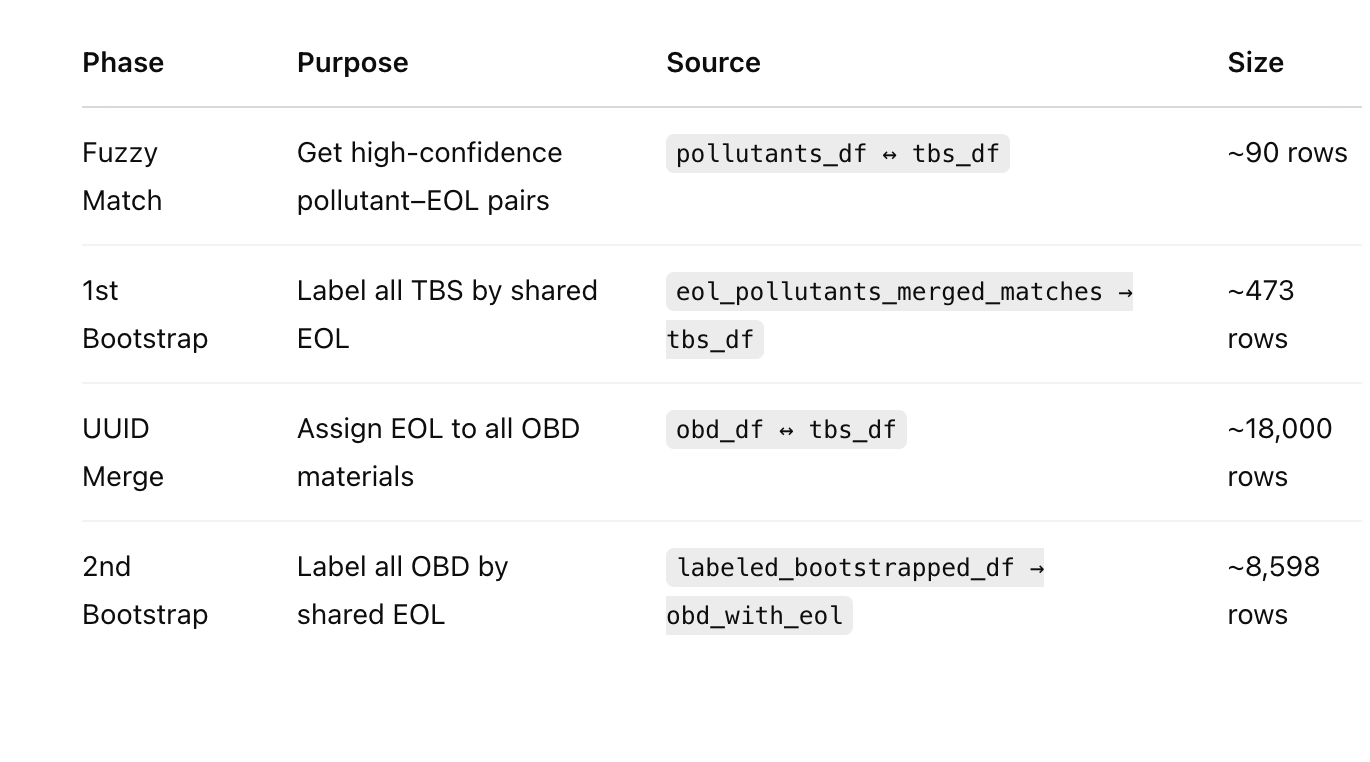

In [237]:
# determine materials that are commonly used together

In [240]:
obd_df_clean[obd_df_clean["UUID"] == "5a65cfa1-6a89-42c0-83b1-4b576cac7405"]

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
